In [76]:
# importing required libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import string
import nltk

from operator import index

import gensim
import gensim.corpora as corpora
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

from collections import Counter
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [28]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [20]:
#initialization
stop = stopwords.words('english')
symbols = list(string.punctuation)

In [2]:
# loading datasets
fakeDataset = pd.read_csv("./dataset/Fake.csv")
trueDataset = pd.read_csv("./dataset/True.csv")

In [5]:
# top-5 rows
display(fakeDataset.head())

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
display(trueDataset.head())

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
# adding label column
fakeDataset["label"] = "1"
trueDataset["label"] = "0"

In [60]:
# merging datasets
data = [fakeDataset, trueDataset]
dataset = pd.concat(data, ignore_index=True, sort=False)

# # Use pandas.concat() method to ignore_index
# df2 = pd.concat([df, df1], ignore_index=True, sort=False)

In [18]:
# dimensions
print(
    "Total number of rows in Fake Dataset {} and True Dataset {} and combined dataset {}"
    .format(fakeDataset.shape, trueDataset.shape, dataset.shape))

Total number of rows in Fake Dataset (23481, 5) and True Dataset (21417, 5) and combined dataset (44898, 2)


In [15]:
dataset.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [16]:
# dropping unneccessary columns
columns = ['title', 'subject', 'date']
dataset.drop(columns=columns, inplace=True)

In [17]:
# after dropping columns
display(dataset.head())

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [23]:
# checking for NaN values
display(dataset.isna().any())

text     False
label    False
dtype: bool

In [24]:
# checking for null values
display(dataset.isnull().any())

text     False
label    False
dtype: bool

In [21]:
# Dataset preprocessing
def cleaning(raw):
    htmlFree = BeautifulSoup(raw, "html.parser")  # removing html tags
    # removing numbers and others except small and capital alphabets
    letters = re.sub("[^a-zA-Z ]", " ", htmlFree.get_text())
    low = letters.lower()  # Converting everything to lower case
    words = low.split()  # spiliting sentences into words
    cleaned = [w for w in words if not w in stop]  # removing stopping words
    return ' '.join(cleaned)

In [61]:
# cleaning the dataset and segregating input and output
x = list(map(cleaning, dataset['text']))
y = dataset['label']

In [36]:
# dataset visualisation
def get_list_of_words(document):
    Document = [a.split(" ") for a in document]
    return Document


document = get_list_of_words(x[:1000])

id2word = corpora.Dictionary(document)
corpus = [id2word.doc2bow(text) for text in document]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, random_state=100,
                                            update_every=3, chunksize=100, passes=50, alpha='auto',
                                            per_word_topics=True)


In [37]:
def format_topics_sentences(ldamodel, corpus):
    sent_topics_df = []
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.append(
                    [i, int(topic_num), round(prop_topic, 4) * 100, topic_keywords])
            else:
                break

    return sent_topics_df

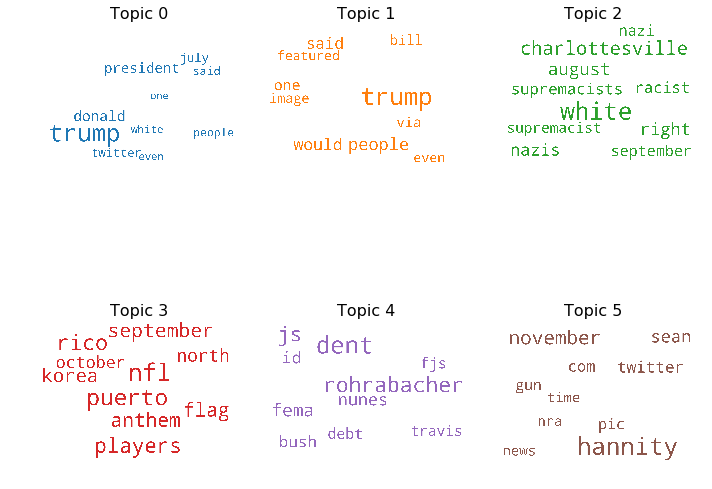

In [39]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  collocations=False,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

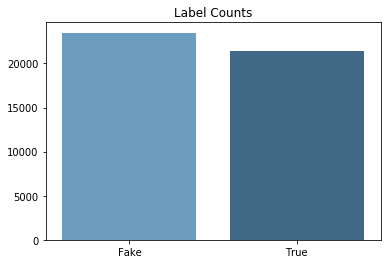

In [47]:
# bar chart for labels
cnt = Counter(y)
yval = list(cnt.values())
xval = list(cnt.keys())
sns.barplot(x=['Fake', "True"], y=yval, palette="Blues_d")
plt.title("Label Counts")
plt.show()

In [53]:
# vector embedding
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 200

In [52]:
# 
maxlen = 0
word_freqs = Counter()
num_recs = 0

for line in x:
    sentence = line.strip()
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1

In [54]:
# vector embedding initailsation
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

X = np.empty((num_recs, ), dtype=list)
Y = np.zeros((num_recs, ))

In [62]:
# vectorisations
i = 0
for idx, line in enumerate(x):
    sentence = line.strip()
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    Y[i] = int(y[idx])
    i += 1

In [63]:
# padding the sequences
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [65]:
# splitting the dataset for train & test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [66]:
# defining model
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
model.add(Dropout(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [67]:
# summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           256256    
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 305,729
Trainable params: 305,729
Non-trainable params: 0
_________________________________________________________________


In [68]:
# training the model
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

Train on 35918 samples, validate on 8980 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
35918/35918 [==============================] - 50s 1ms/sample - loss: 0.1525 - acc: 0.9416 - val_loss: 0.1268 - val_acc: 0.9514
Epoch 2/10
35918/35918 [==============================] - 64s 2ms/sample - loss: 0.0899 - acc: 0.9682 - val_loss: 0.0992 - val_acc: 0.9647
Epoch 3/10
35918/35918 [==============================] - 61s 2ms/sample - loss: 0.0723 - acc: 0.9745 - val_loss: 0.1024 - val_acc: 0.9671
Epoch 4/10
35918/35918 [==============================] - 65s 2ms/sample - loss: 0.0591 - acc: 0.9787 - val_loss: 0.0911 - val_acc: 0.9695
Epoch 5/10
35918/35918 [==============================] - 68s 2ms/sample - loss: 0.0475 - acc: 0.9828 - val_loss: 0.1068 - val_acc: 0.9670
Epoch 6/10
35918/35918 [==============================] - 66s 2ms/sample - loss: 0.0374 - acc: 0.9862 - val_loss: 0.1036 - val_acc: 0.9682
Epoch 7/10
35918/35918 [==============================] - 67s 2ms/sam

In [69]:
# evaluating the model
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print(("Test score: %.3f, accuracy: %.3f" % (score, acc)))

8980/8980 [==============================] - 2s 238us/sample - loss: 0.1276 - acc: 0.9710
Test score: 0.128, accuracy: 0.971


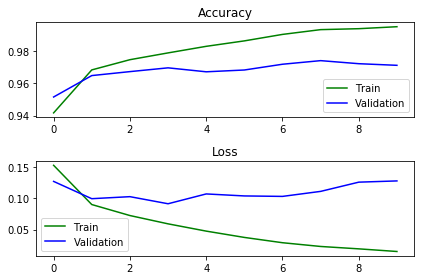

In [70]:
# graph to represent the training and validation
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [74]:
from prettytable import PrettyTable
  
myTable = PrettyTable(["Predicted", "Actual", "Sentence"])
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1, 40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    myTable.add_row([int(ypred), ylabel, sent])
print(myTable)

+-----------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Predicted | Actual |                                                                                                                            Sentence                                                                                                                           |
+-----------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     0     |  1.0   |      obama former political director national democratic UNK committee launched last month obama UNK eric UNK end obama call gop UNK congres

In [86]:
print(classification_report(ytest, [round(i[0]) for i in model.predict(Xtest)]))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      4247
         1.0       0.97      0.98      0.97      4733

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



In [88]:
print(accuracy_score(ytest, [round(i[0]) for i in model.predict(Xtest)]))

0.9710467706013363
